# Initialize

In [1]:
from pupil_apriltags import Detector, Detection
from collections import defaultdict
from typing import List, Dict, Tuple, Any
from glob import glob
import numpy as np
import os
import time
import sys
import cv2
from math import atan2, degrees
import platform
import socket
import matplotlib.pyplot as plt
import math
from statsFuncs import trigonometry as trig
from statsFuncs import numbers
import pandas as pd
import utils
import multiprocessing
from joblib import Parallel, delayed
from numpy import save
import pupil_functions
import decimal

# load data 

In [12]:
datapath = os.getcwd() + '/data/'

if platform.system() == 'Darwin':
    EM_path = '/Users/teresa/Dropbox/Naive_Spring_Eye_Recordings_TCB/Subject_CG/003/'    
elif platform.system() == 'Linux':
    EM_path = '/home/teresa/Documents/Naive_Spring_Eye_Recordings_TCB/Subject_CG/003/'

In [13]:
behavioral_data = pd.read_csv(datapath + 'S1_AdjustEyeTrack_2019_Dec_03_1223.csv')
# annotation_data = pd.read_csv(datapath + 'pl_msgs.csv')
timestamp_path = EM_path + 'world_timestamps.npy'

# Set up parallel computing 

In [14]:
num_cores = multiprocessing.cpu_count()

# Extract frames 

Create frame path using OS package
Define the name of the directory to be created

In [15]:
video_path = EM_path + 'world.mp4'
frames_path = EM_path + 'frames'

try:
    if not os.path.exists(frames_path):
        os.mkdir(frames_path)
        print("Successfully created the directory %s " % frames_path)
    else:
        print("Directory already exists %s " % frames_path)
except OSError:
    print("Creation of the directory %s failed" % frames_path)


Directory already exists /Users/teresa/Dropbox/Naive_Spring_Eye_Recordings_TCB/Subject_CG/003/frames 


How many frames does the video have?

In [16]:
cap = cv2.VideoCapture(video_path)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(total_frames)

28660


No need to do the extract frames if they have been extracted before.

In [17]:
if not len(os.listdir(frames_path)) == total_frames:
    utils.extract_frames(video_path, frames_path, total_frames)
else:
    print('Frames previously extracted, moving forward')



Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Extracted 28660 frames from /Users/teresa/Dropbox/Naive_Spring_Eye_Recordings_TCB/Subject_CG/003/world.mp4.


In [22]:
#------- fixing np load issue ------
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

#------- finished np load issue ------

frames_file = datapath + 'frames.npy'
tags_path = datapath + 'tag_ids.npy'

if not os.path.exists(datapath + 'frames.npy'):
    print('Detecting tags, it will take some time...')
    frames, tag_ids = utils.detect_tags(frames_file)
    print('Done! Saving results...')
    save(frames_file, frames)
    save(tags_path, tag_ids)
    print('Done!') 
else:
    print('Tags per frame were already extracted, loading the files....')
    frames = np.load(frames_file)
    tag_ids = np.load(tags_path)
    print('Frames and tag IDs were loaded')

#------restore np load ------
# restore np.load for future normal usage
np.load = np_load_old

Detecting tags, it will take some time...
0


ZeroDivisionError: float division by zero

In [19]:
# Descriptive print statements
tag_count = sum(count for count in tag_ids.values())
print(f'Detected {tag_count} tags in {len(frames)} frames.')
print(f'Found IDs of {list(tag_ids.keys())}.')

AttributeError: 'numpy.ndarray' object has no attribute 'values'

Check in how many of the frames it didn't find 10 tags

# Annotations 

In [ ]:
annotation_data = pupil_functions.load_annotations(EM_path)

# Timestamps 

In [ ]:
world_timestamps = np.load(timestamp_path)
world_timestamps_df = pd.DataFrame(index=range(total_frames), columns=['FRAME','TIMESTAMP'])
world_timestamps_df['TIMESTAMP'] = world_timestamps
world_timestamps_df['FRAME'] = range(total_frames)

In [ ]:
world_timestamps_df['TIMESTAMP_ROUND'] = round(world_timestamps_df['TIMESTAMP'], 4)
annotation_data['timestamp_round'] = round(annotation_data['timestamp'], 4)

Note that first frame is frame 0

In [ ]:
# Find timestamp where experiment begins:
exp_beging_ts = np.float64(annotation_data.loc[annotation_data['exp_event'] == 'Block 1 Begins', 'timestamp_round'])

# find frame for that timestamp
exp_beging_fr = world_timestamps_df.loc[world_timestamps_df['TIMESTAMP_ROUND'] == numbers.closest(world_timestamps_df['TIMESTAMP_ROUND'], exp_beging_ts), 'FRAME']

In [14]:
for annotation_idx in range(len(annotation_data)):
    
    msg = annotation_data.loc[annotation_idx, 'exp_event']
    msg_ts = annotation_data.loc[annotation_idx, 'timestamp']
    
    closest_ts = numbers.closest(world_timestamps_df['TIMESTAMP'], msg_ts)
    # find frame:
    msg_frame = int(world_timestamps_df.loc[world_timestamps_df['TIMESTAMP'] == closest_ts, 'FRAME'])
    
    annotation_data.loc[annotation_idx, 'frame'] = msg_frame

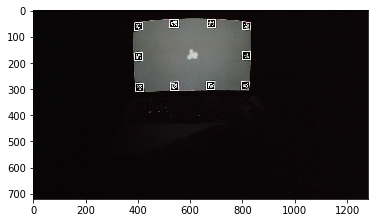

In [18]:
image = cv2.imread(frames_path + '/frame' + str(2803) + '.png')
plt.imshow(image)

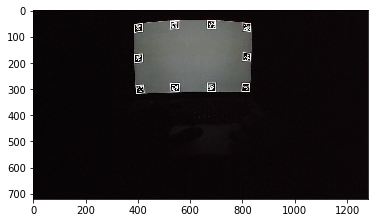

In [27]:
image = cv2.imread(frames_path + '/frame' + str(2837) + '.png')
plt.imshow(image)

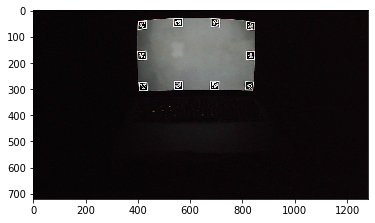

In [20]:
image = cv2.imread(frames_path + '/frame' + str(2805) + '.png')
plt.imshow(image)

# Trial loop 

In [ ]:
numTrials = len(behavioral_data)
numBlocks = behavioral_data.blockNumber.unique()

In [ ]:
for block in numBlocks:
    for trial in range(numTrials):
    
    # find frames hwere trial happens
    trial_data = annotation_data[(annotation_data['block'] == block) & (annotation_data['trial'] == trial + 1)]